In [2]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

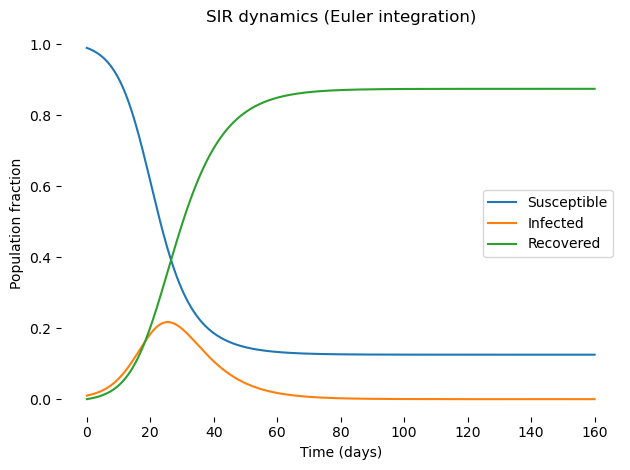

In [5]:
# Simple Euler integration of the classic SIR model
beta = 0.33    # transmission rate
gamma = 0.14   # recovery rate
N = 1.0       # population (normalised to 1)

# Initial conditions: 0.1 % infected, rest susceptible
S0, I0, R0 = 0.99, 0.01, 0.0

t_max, dt = 160, 0.1
n_steps = int(t_max / dt)

S = np.empty(n_steps)
I = np.empty(n_steps)
R = np.empty(n_steps)
t = np.linspace(0, t_max, n_steps)

S[0], I[0], R[0] = S0, I0, R0

for k in range(1, n_steps):
    dS = -beta * S[k-1] * I[k-1]
    dI = beta * S[k-1] * I[k-1] - gamma * I[k-1]
    dR = gamma * I[k-1]

    S[k] = S[k-1] + dS * dt
    I[k] = I[k-1] + dI * dt
    R[k] = R[k-1] + dR * dt

plt.figure()
plt.plot(t, S, label="Susceptible")
plt.plot(t, I, label="Infected")
plt.plot(t, R, label="Recovered")
plt.xlabel("Time (days)")
plt.ylabel("Population fraction")
plt.title("SIR dynamics (Euler integration)")
plt.legend()
plt.tight_layout()
plt.box(False)
plt.show()


SIRD test - bayesian parameter estimation

**SIR normal version test**

Redo test

In [59]:
## SAME PARAMETER ##
beta = 0.33 # Tansmission rate
gamma = 0.14 # Recovery rate
nu = 0.01  # vaccine rate

N = 5_826_529  #Total Population
I0 = 500            # Start Infection
R0_init = 0 #Start recovering from disease
V0 = 0 #Start vaccinated
S0 = N - I0 - R0_init - V0 #Start susceptible


T = 365 #Daily Time Steps
dt = 1 # Simulation updates daily

In [10]:
0.01*N

58265.29

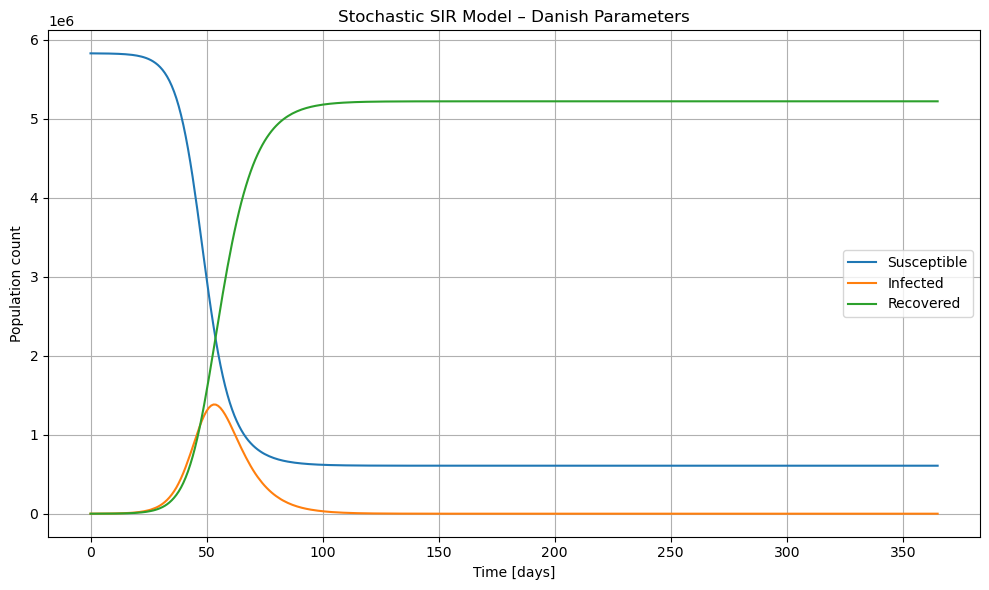

In [60]:
# Arrays to store results
S = np.zeros(T+1, dtype=int)
I = np.zeros(T+1, dtype=int)
R = np.zeros(T+1, dtype=int)
V = np.zeros(T+1, dtype=int)

# Initial conditions
S[0] = S0
I[0] = I0
R[0] = R0_init
V[0] = V0
# Stochastic simulation
for t in range(T):
    # Probabilities for each transition
    p_infect = 1 - np.exp(-beta * I[t] / N)
    p_recover = 1 - np.exp(-gamma)

    # Events sampled from binomial distributions
    new_infect = np.random.binomial(S[t], p_infect)
    new_recover = np.random.binomial(I[t], p_recover)

    # Update states
    S[t+1] = S[t] - new_infect
    I[t+1] = I[t] + new_infect - new_recover
    R[t+1] = R[t] + new_recover

plt.figure(figsize=(10, 6))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Time [days]')
plt.ylabel('Population count')
plt.title('Stochastic SIR Model – Danish Parameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

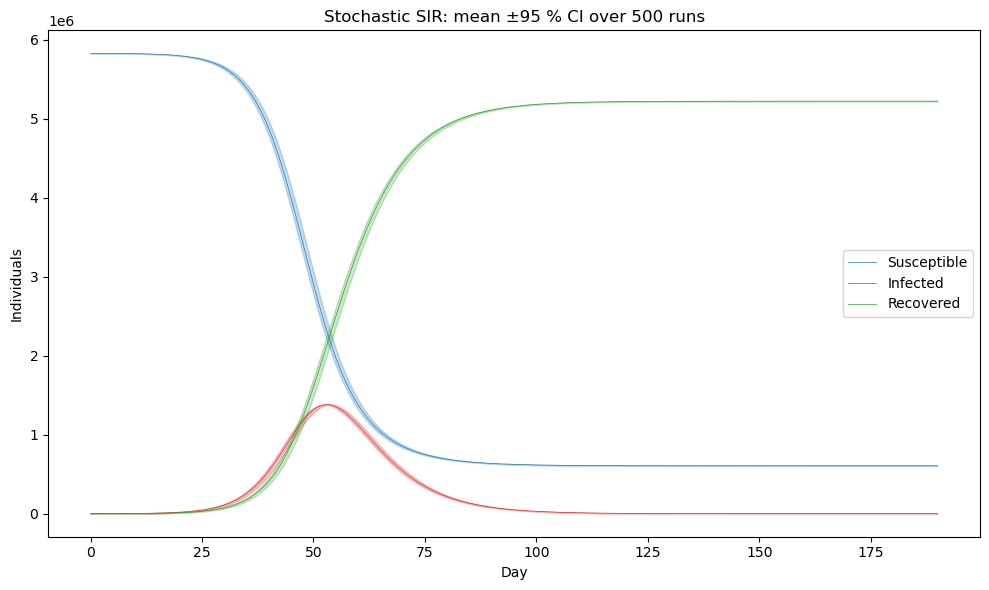

array([[500, 596, 727, ...,   2,   2,   1],
       [500, 608, 744, ...,   7,   6,   6],
       [500, 585, 715, ...,   3,   3,   3],
       ...,
       [500, 617, 718, ...,   0,   0,   0],
       [500, 570, 657, ...,   5,   4,   4],
       [500, 611, 734, ...,  16,  14,   8]])

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. one SIR run --------------------------------------------------
def simulate_sir(S0, I0, R0, beta, gamma, N, T, rng=np.random):
    S = np.zeros(T+1, dtype=int)
    I = np.zeros_like(S)
    R = np.zeros_like(S)

    S[0], I[0], R[0] = S0, I0, R0
    for t in range(T):
        p_inf  = 1 - np.exp(-beta  * I[t] / N)
        p_rec  = 1 - np.exp(-gamma)
        new_inf = rng.binomial(S[t], p_inf)
        new_rec = rng.binomial(I[t], p_rec)

        S[t+1] = S[t] - new_inf
        I[t+1] = I[t] + new_inf - new_rec
        R[t+1] = R[t] + new_rec
    return S, I, R

# ---------- 2. many runs ----------------------------------------------------
n_runs = 500
T      = 190
N = 5_826_529  #Total Population
I0 = 500  
S0, R0 = N-I0, 0
beta, gamma = 0.33, 0.14
N = S0 + I0 + R0

S_runs = np.empty((n_runs, T+1), dtype=int)
I_runs = np.empty_like(S_runs)
R_runs = np.empty_like(S_runs)

for r in range(n_runs):
    S_traj, I_traj, R_traj = simulate_sir(S0, I0, R0, beta, gamma, N, T)
    S_runs[r], I_runs[r], R_runs[r] = S_traj, I_traj, R_traj

# ---------- 3. mean and 95 % CI --------------------------------------------
def mean_ci(arr):
    mean = arr.mean(axis=0)
    low  = np.percentile(arr, 2.5,  axis=0)
    high = np.percentile(arr, 97.5, axis=0)
    return mean, low, high

S_mean, S_low, S_high = mean_ci(S_runs)
I_mean, I_low, I_high = mean_ci(I_runs)
R_mean, R_low, R_high = mean_ci(R_runs)
t = np.arange(T+1)

# ---------- 4. plot ---------------------------------------------------------
plt.figure(figsize=(10,6))
for mean, low, high, lbl, clr in [
    (S_mean, S_low, S_high, 'Susceptible', 'tab:blue'),
    (I_mean, I_low, I_high, 'Infected',    'tab:red'),
    (R_mean, R_low, R_high, 'Recovered',   'tab:green')]:
    plt.plot(t, mean, color=clr, label=lbl, lw=0.5,)
    plt.fill_between(t, low, high, color=clr, alpha=0.25)

plt.xlabel('Day'); plt.ylabel('Individuals')
plt.title(f'Stochastic SIR: mean ±95 % CI over {n_runs} runs')
plt.legend(); plt.tight_layout(); plt.show()

I_runs

**SIRD**


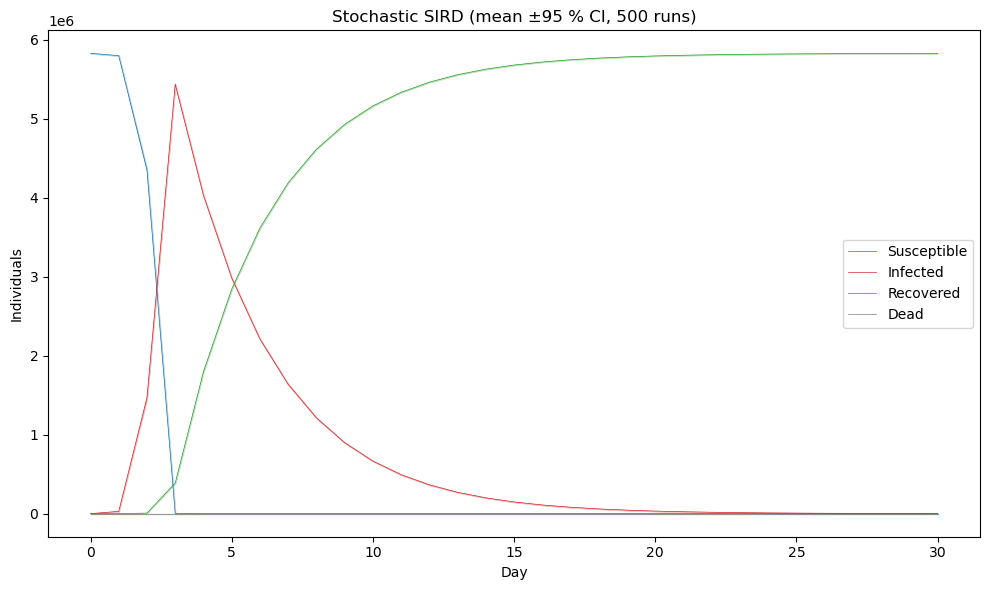

In [69]:
# -------------------------------------------------------------------
# 1. One stochastic S I R D trajectory
# -------------------------------------------------------------------
def simulate_sird(S0, I0, R0, D0, beta, gamma, mu, N, T,k, rng=np.random):
    S = np.zeros(T+1, dtype=int)
    I = np.zeros_like(S)
    R = np.zeros_like(S)
    D = np.zeros_like(S)

    S[0], I[0], R[0], D[0] = S0, I0, R0, D0
    for t in range(T):
        # --- per-step probabilities ---------------------------------
        p_inf  = 1 - (k/(k+beta*I[t]))**k   # infection
        p_rec  = 1 - np.exp(-gamma)              # recovery
        p_die  = 1 - np.exp(-mu)                 # death given still infected

        # --- Binomial draws ----------------------------------------
        new_inf = rng.binomial(S[t], p_inf)
        new_rec = rng.binomial(I[t], p_rec)
        # deaths are taken from those who did not recover
        new_die = rng.binomial(I[t] - new_rec, p_die)

        # --- update compartments -----------------------------------
        S[t+1] = S[t] - new_inf
        I[t+1] = I[t] + new_inf - new_rec - new_die
        R[t+1] = R[t] + new_rec
        D[t+1] = D[t] + new_die
    return S, I, R, D

# -------------------------------------------------------------------
# 2. Monte-Carlo wrapper
# -------------------------------------------------------------------
n_runs = 500
T      = 30
N = 5_826_529  #Total Population
I0 = 500  
S0, R0, D0 = N-I0, 0, 0
beta, gamma, mu, k = 0.00001, 0.3, 0.0, 6
N = S0 + I0 + R0 + D0

shape = (n_runs, T+1)
S_runs = np.empty(shape, int)
I_runs = np.empty_like(S_runs)
R_runs = np.empty_like(S_runs)
D_runs = np.empty_like(S_runs)

for r in range(n_runs):
    S_tr, I_tr, R_tr, D_tr = simulate_sird(
        S0, I0, R0, D0, beta, gamma, mu, N, T,k
    )
    S_runs[r], I_runs[r], R_runs[r], D_runs[r] = S_tr, I_tr, R_tr, D_tr

# -------------------------------------------------------------------
# 3. Mean and 95 % CI helper
# -------------------------------------------------------------------
def mean_ci(arr):
    mean = arr.mean(axis=0)
    low  = np.percentile(arr, 2.5,  axis=0)
    high = np.percentile(arr, 97.5, axis=0)
    return mean, low, high

curves = []
for runs in (S_runs, I_runs, R_runs, D_runs):
    curves.append(mean_ci(runs))
labels = ['Susceptible', 'Infected', 'Recovered', 'Dead']
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:gray']
t = np.arange(T+1)

# -------------------------------------------------------------------
# 4. Plot
# -------------------------------------------------------------------
plt.figure(figsize=(10,6))
for (mean, low, high), lbl, clr in zip(curves, labels, colors):
    plt.plot(t, mean, color=clr, label=lbl, lw=0.5)
    plt.fill_between(t, low, high, color=clr, alpha=0.25)

plt.xlabel('Day'); plt.ylabel('Individuals')
plt.title(f'Stochastic SIRD (mean ±95 % CI, {n_runs} runs)')
plt.legend(); plt.tight_layout(); plt.show()
